# Vladislav Abramov and Sergei Garshin DSBA182

## The Task
### Что ждем от туториала?

1. Оценить конкретную модель заданного класса. Не только сделать .fit, но и выписать полученное уравнение!
2. Автоматически подобрать модель (встроенный подбор)
3. Построить графики прогнозов, интервальные прогнозы где есть.
4. Сравнить несколько (две-три) модели данного класса с помощью скользящего окна.
5. Творчество, любые дополнения, мемасики :)

### Класс выбираем: ETS, ARIMA, BATS + TBATS, PROPHET, случайный лес + создание признаков, GARCH, своё предложить

### Цель: когда через год будут люди спрашивать "как в питоне оценить ets/arima?" ответ должен быть "читайте туториалы от нашего курса!"

---
---
---
# Real Data Analysis with ARIMA models

Let's begin with collecting stock data

In [1]:
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima, ARIMA, ADFTest
from sklearn.metrics import mean_squared_error
from math import sqrt
from tqdm import tqdm
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

def should_diff(data):
    adf_test = ADFTest(alpha = 0.05)
    return adf_test.should_diff(data)

def get_stock_data(ticker, start, end):
    tickerData = yf.Ticker(ticker)
    tickerDf = tickerData.history(period='1d', start = start, end = end)
    return tickerDf

def train_test_devision(n, data):
    train = data[:-n]
    test = data[-n:]
    return train, test

def differentiate_data(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return diff

def autocorrelation_plot(data):
    data = np.array(data)**2
    plot_acf(data)
    plt.show()
    
def p_autocorrelation_plot(data):
    data = np.array(data)**2
    plot_pacf(data)
    plt.show()

In [2]:
data = get_stock_data('AAPL', '2015-1-1', '2021-2-1')
data.head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02,25.367691,25.379078,24.447631,24.898552,212818400,0.0,0.0
2015-01-05,24.661702,24.743687,24.005818,24.197117,257142000,0.0,0.0
2015-01-06,24.263166,24.465853,23.828187,24.199400,263188400,0.0,0.0
2015-01-07,24.413472,24.641210,24.299604,24.538729,160423600,0.0,0.0
2015-01-08,24.875777,25.540770,24.755074,25.481558,237458000,0.0,0.0
2015-01-09,25.659194,25.791282,25.098960,25.508888,214798000,0.0,0.0
2015-01-12,25.643252,25.650083,24.777850,24.880331,198603200,0.0,0.0
2015-01-13,25.376804,25.688806,24.802906,25.101242,268367600,0.0,0.0
2015-01-14,24.832507,25.162726,24.709529,25.005589,195826400,0.0,0.0


---
Here we may observe the graph of stock price for Apple Inc. on the perios 1st Jan 2015 till 1st Feb 2021

Text(0.5, 1.0, 'Close Stock Prices')

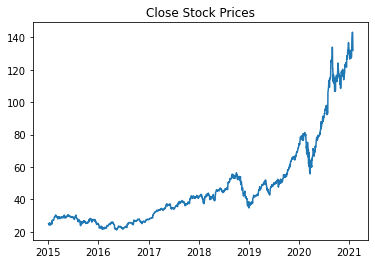

In [3]:
plt.plot(data['Close'])
plt.title('Close Stock Prices')

---
Looking at the graph it is obvious that data is not stationary and has a strong trend. However, lets make sure that data is not stationary by Autocorrelation plot and Augmented Dickey-Fuller test.

Should differentiate? : (0.99, True)

ACF of undifferentiated data


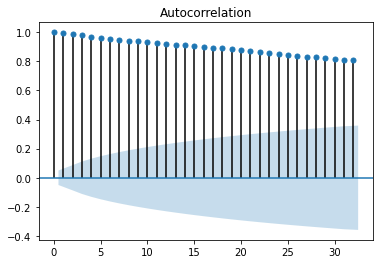

In [4]:
print('Should differentiate? :', should_diff(data['Close']))
print()
print('ACF of undifferentiated data')
autocorrelation_plot(data['Close'])

---
As we can see, we were right, the data is not stationary!

## Stationarity check & convertion data to stationary
For now, lets differentiate our initial stock data to build a stationary graph of deltas

Text(0.5, 1.0, 'Stationary stock data plot')

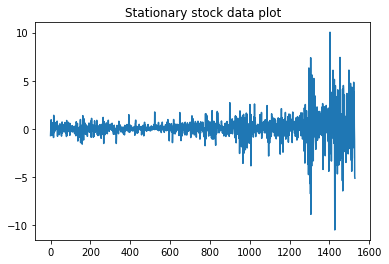

In [5]:
X = pd.DataFrame()
X['Diff_Close'] = differentiate_data(data['Close'])
plt.plot(X['Diff_Close'])
plt.title('Stationary stock data plot')

As we may notice we have vanished trend and made the data much more stationary than it was before, for the next step, lets check the stationary feature by Autocorrelation, Partial Autocorrelation plot and Augmented Dickey-Fuller test again.

Should differentiate? : (0.01, False)

ACF of differentiated data


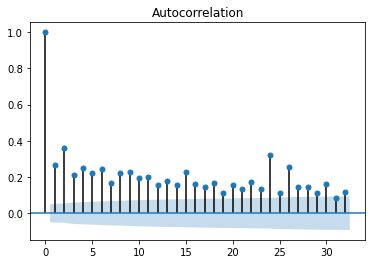

In [6]:
print('Should differentiate? :', should_diff(X['Diff_Close']))
print()
print('ACF of differentiated data')
autocorrelation_plot(X['Diff_Close'])

PACF of differentiated data


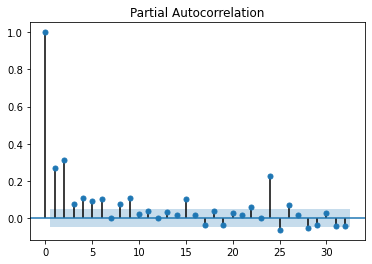

In [7]:
print('PACF of differentiated data')
p_autocorrelation_plot(X['Diff_Close'])

Wow! The data has become stationary! We may go further!

---

## Train / Test devision

On this step we have devide our data into two parts, train and test. Our model will use the training set to make predictions and compare them with testing set.

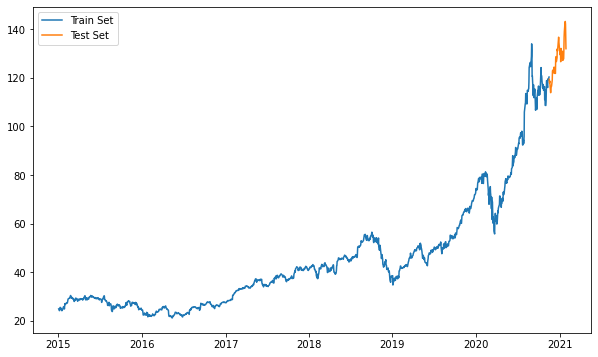

In [8]:
n = 50
train, test = train_test_devision(n, data['Close'])

fig, ax = plt.subplots()
ax.plot(train, label = 'Train Set')
ax.plot(test, label = 'Test Set')
fig.set_figheight(6)
fig.set_figwidth(10)
ax.legend()

---
# Manual Model
In this part we have decided to train ARIMA(3,1,2) model, where p = 3 AR parts, d = 1 as we need 1 differentiation and q = 2 MA parts

In [9]:
X = data['Close'].values
size = len(train.values)
train, test = train.values, test.values
history = [x for x in train]
predictions, CI = [],[]

for t in tqdm(range(len(test))):
    model = ARIMA((3,1,2))
    model.fit(history)
    y_hat, conf_int = model.predict(n_periods = 1, return_conf_int = True, alpha=0.05)
    predictions.append(y_hat)
    CI.append(conf_int)
    
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))


100%|██████████| 50/50 [01:34<00:00,  1.90s/it]


Test RMSE: 2.686
Test R^2: 0.861


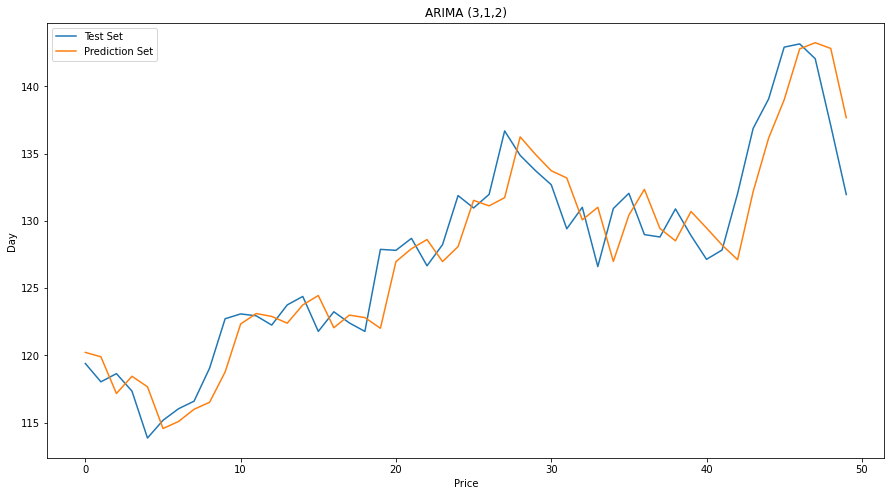

In [10]:

rmse = sqrt(mean_squared_error(test, predictions))
r_squared = r2_score(test, predictions)
print('Test RMSE: %.3f' % rmse)
print('Test R^2: %.3f' % r_squared)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(test, label = 'Test Set')
ax.plot(predictions, label = 'Prediction Set')
ax.set_title('ARIMA (3,1,2)')
ax.set_xlabel('Price')
ax.set_ylabel('Day')
ax.legend()

In [11]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1529
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -2472.683
Date:                Wed, 03 Feb 2021   AIC                           4959.365
Time:                        17:42:56   BIC                           4996.687
Sample:                             0   HQIC                          4973.256
                               - 1529                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0862      0.101      0.850      0.395      -0.113       0.285
ar.L1         -0.0090      0.926     -0.010      0.992      -1.824       1.806
ar.L2         -0.1220      0.456     -0.267      0.789      -1.016       0.773
ar.L3         -0.0377      0.039     -0.978      0.328      -0.113       0.038
ma.L1         -0.1042      0.927     -0.112      0.911      -1.920       1.712
ma.L2          0.1690      0.386      0.438      0.661      -0.587       0.925
sigma2         1.4897      0.018     82.109      0.000       1.454       1.525
===================================================================================
Ljung-Box (Q):                      150.40   Jarque-Bera (JB):             16051.22
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.56   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## The ARIMA equation we got
$\Delta y_t = -0.0090 \Delta y_{t-1} -0.1220 \Delta y_{t-2} -0.0377 \Delta y_{t-3} -0.1042 \varepsilon_{t-1} -0.1690 y_{t-2}\varepsilon_{t-2}$          
 where  $\\ \Delta y_t = y_t - y_{t-1}$

As we may se the model works pretty well

---

## Automatic choice of the model
In this section we would like to play with autosetting parameters, which also include sesonal dependency

In [12]:
n = 50
train, test = train_test_devision(n, data['Close'])
model  = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace = True,
                           error_action='ignore',  
                           suppress_warnings = True, 
                           stepwise = True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5576.311, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5269.709, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.32 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=5555.152, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=4987.970, Time=0.89 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.17 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.78 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=5005.838, Time=0.68 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=4988.582, Time=1.08 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=4988.071, Time=1.61 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=4989.152, Time=0.82 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=4990.030, Time=2.46 sec
 ARIMA(1,1,0)(2,1,0)[12] intercept   : AIC=4989.964, Time=3.35 sec

Best model:  ARIMA(1,1,0)(2,1,0)[12]  

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1480
Model:             SARIMAX(1, 1, 0)x(2, 1, 0, 12)   Log Likelihood               -2489.985
Date:                            Wed, 03 Feb 2021   AIC                           4987.970
Time:                                    17:43:16   BIC                           5009.133
Sample:                                         0   HQIC                          4995.863
                                           - 1480                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1170      0.012     -9.881      0.000      -0.140      -0.094
ar.S.L12      -0.6105      0.012    -50.411      0.000      -0.634      -0.587
ar.S.L24      -0.4447      0.011    -40.126      0.000      -0.466      -0.423
sigma2         1.7360      0.025     70.677      0.000       1.688       1.784
===================================================================================
Ljung-Box (Q):                      304.66   Jarque-Bera (JB):             16019.61
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              19.32   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
y_hat, conf_int = model.predict(n_periods = n, return_conf_int = True, alpha=0.05)
predictions = pd.DataFrame(y_hat, index = test.index, columns = ['Prediction'])
CI = pd.DataFrame({'CI lower': conf_int[:, 0], 'CI upper': conf_int[:, 1]}, index = test.index)

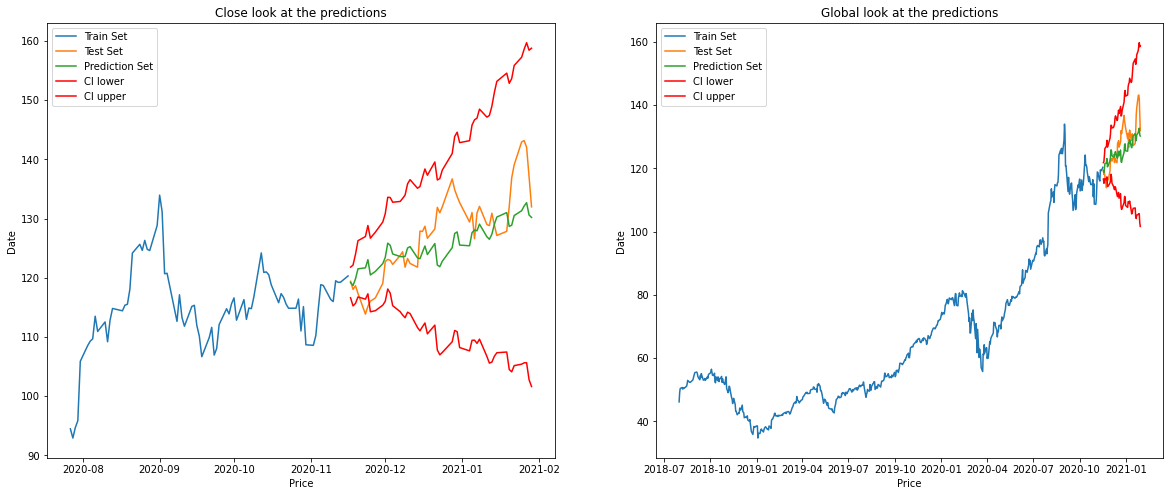

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))

ax1.plot(train[1400:], label = 'Train Set')
ax1.plot(test, label = 'Test Set')
ax1.plot(predictions, label = 'Prediction Set')
ax1.plot(CI['CI lower'], label = 'CI lower', c = 'r')
ax1.plot(CI['CI upper'], label = 'CI upper', c = 'r')
ax1.set_title('Close look at the predictions')
ax1.set_xlabel('Price')
ax1.set_ylabel('Date')
ax1.legend()

ax2.plot(train[900:], label = 'Train Set')
ax2.plot(test, label = 'Test Set')
ax2.plot(predictions, label = 'Prediction Set')
ax2.plot(CI['CI lower'], label = 'CI lower', c = 'r')
ax2.plot(CI['CI upper'], label = 'CI upper', c = 'r')
ax2.set_title('Global look at the predictions')
ax2.set_xlabel('Price')
ax2.set_ylabel('Date')
ax2.legend()

To observe the data we have built two graphs, the left one catches more localy than the right one.

---
---
---

К сожалению, на вечер среды мы не успели выполнить все пункиы и дать подробное описание нашим шагам. Очень просим прокоммментировать выполненные этапы, дать советы и наставления :)